In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
(train_images,train_labels),(test_images,test_labels) =tf.keras.datasets.mnist.load_data()

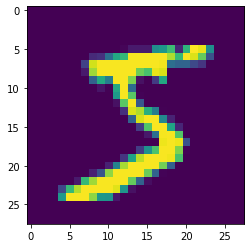

In [3]:
plt.imshow(train_images[0])

In [4]:
train_images=train_images.reshape(train_images.shape[0],28,28,1)

In [5]:
train_images = (train_images-127.5)/127.5

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# Discriminator

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(7, (3, 3), padding='same', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(50, activation="relu"))
    model.add(tf.keras.layers.Dense(1))
    return model

In [8]:
model_discriminator = make_discriminator_model()

In [9]:
model_discriminator(np.random.rand(1,28,28,1).astype("float64"))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.3122606]], dtype=float32)>

In [10]:
discriminator_optimizer=tf.optimizers.Adam(1e-3)

In [11]:
def get_discriminator_loss(real_predictions,fake_predictions):
    real_predictions = tf.sigmoid(real_predictions)
    fake_predictions = tf.sigmoid(fake_predictions)
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions),real_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions),fake_predictions)
    return real_loss+ fake_loss


# Generator

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256,input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    model.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same'))
    return model


In [13]:
generator=make_generator_model()

In [14]:
generator_optimizer = tf.optimizers.Adam(1e-4)

In [15]:
def get_generator_loss(fake_predictions):
    fake_predictions = tf.sigmoid(fake_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions),fake_predictions)
    return fake_loss


# Training

In [16]:
def train(dataset, epochs):
    for _ in range(epochs):
        for images in dataset:
            images = tf.cast(images,tf.datatypes.float64)
            train_step(images)


In [17]:
def train_step(images,old_gen_loss,old_disc_loss):
    fake_image_noise = np.random.randn(BATCH_SIZE, 100).astype("float64")
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(fake_image_noise)
        real_output = model_discriminator(images)
        fake_output = model_discriminator(generated_images)
        gen_loss = get_generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, model_discriminator.trainable_variables))
        print("generator loss: ",np.mean(gen_loss))
        print("discriminator loss: ",np.mean(disc_loss))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



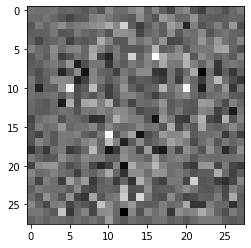

In [18]:
plt.imshow(tf.reshape(generator(np.random.randn(1,100)),(28,28)),cmap="gray")